# Linear transducer with an abdominal wall target and air inclusions.

This Jupyter notebook provides an advanced usage of Fullwave 2.5.

## Overview

In this example, we simulate a linear transducer emitting ultrasound waves into a medium that includes an abdominal wall target and air inclusions. The simulation captures the wave propagation and interaction with the target and inclusions.

## Simulation Setup

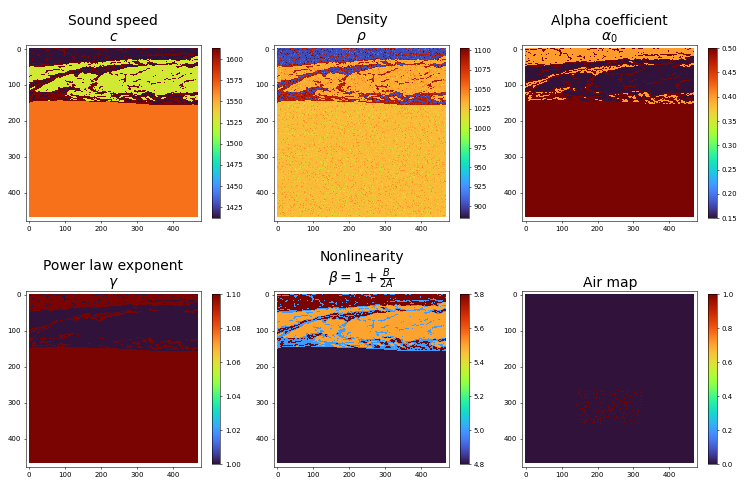

## Wave Propagation Snapshot

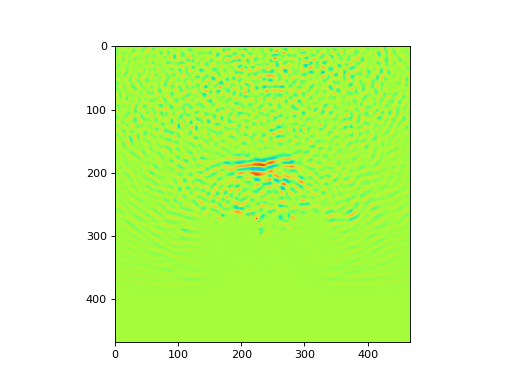


## Prerequisites

Before running this notebook, ensure that you have Fullwave 2.5 and its dependencies installed.

You can follow the installation instructions provided in the [Fullwave 2.5 GitHub repository](https://github.com/pinton-lab/fullwave25#install)


## Basic steps

The basic steps are as follows:

1. Preparation
   1. Import necessary libraries and modules.
   2. Define the working directory.
2. Simulation configuration
   1. Define the computational grid parameters. (`fullwave.Grid`)
   2. Define the acoustic medium properties. (`fullwave.Medium`)
   3. Define the transducer parameters. (`fullwave.Transducer`)
   4. Define the sensor parameters. (`fullwave.Sensor`)
3. Simulation setup
   1. Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)
   2. Execute the simulation.
4. Post-process
   1. Load the recorded wavefield data.
   2. visualize the results.


## Step 1: Preparation

### Step 1.1: Import necessary libraries and modules

In this step, we import the required libraries and modules for the simulation. We use `pathlib` for handling file paths, `numpy` for numerical operations, and `fullwave` along with its utility functions for wave propagation simulations and data visualization.


In [ ]:
# pathlib for handling file paths
from pathlib import Path

# numpy for numerical operations
import numpy as np

# fullwave library and its utility functions
import fullwave
from fullwave import MediumBuilder, presets
from fullwave.constants import MaterialProperties
from fullwave.utils import plot_utils, signal_process

### Step 1.2: Define the working directory

In this step, we set up the working directory where simulation outputs will be saved.
Using the `Path` module from the `pathlib` library, we define the path to the working directory.


In [2]:
# we will make a working directory called "simple_plane_wave" inside "outputs" directory.
work_dir = Path("./outputs/") / "linear_transducer"

# create the working directory if it does not exist
work_dir.mkdir(parents=True, exist_ok=True)

## Step 2

### Step 2.1: Define the computational grid parameters. (`fullwave.Grid`)

In this step, we define the computational grid parameters using the `fullwave.Grid` class. This includes specifying the domain size (`domain_size`) in meters, center frequency (`f0`) of the source in Hz, base sound speed (`c0`) in m/s, and duration (`duration`) of the simulation in seconds.

As an optional step, we can also define spatial resolution (`ppw`) and temporal resolution (`cfl`). If not specified, these will be set to default values.


In [3]:
domain_size = (6e-2, 6e-2)  # [axial, lateral] meters
f0 = 1e6
c0 = 1540
duration = domain_size[0] / c0 * 2  # seconds

# setup the Grid instance
grid = fullwave.Grid(
    domain_size=domain_size,
    f0=f0,
    duration=duration,
    c0=c0,
)

You can print the summary more easily by using the `print_grid_info` function.


In [4]:
grid.print_info()

Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.00e-02 m, 6.00e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 7.79e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (468, 468)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4675
  is 3D simulation (grid.is_3d): False


`grid.summary()` can also be used to print the grid summary. This is an alias to `grid.print_info()`.


In [5]:
grid.summary()

Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.00e-02 m, 6.00e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 7.79e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (468, 468)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4675
  is 3D simulation (grid.is_3d): False


### Step 2.2: Define the acoustic medium properties. (`fullwave.Medium`)

In this step, we define the acoustic medium properties using the `fullwave.Medium` and `fullwave.mediumu_builder.MediumBuilder`.

We specify the sound speed (`c`), density (`rho`), attenuation coefficient (`alpha_coeff`), attenuation power law exponent (`alpha_power`), and nonlinearity parameter (`beta`) of the medium as 2D NumPy arrays.

In this example, the medium is initialized with a uniform value, and an object with different properties is embedded in the center of the medium.


First, we define the base medium properties as 2D NumPy arrays.


In [6]:
# define background
background_property_name = "liver"
material_properties = MaterialProperties()
background = presets.BackgroundDomain(
    grid=grid,
    background_property_name=background_property_name,
)
# define abdominal wall
abdominal_wall = presets.AbdominalWallDomain(
    grid=grid,
)

geometry = np.zeros((grid.nx, grid.ny))
air_location = np.array(
    [
        [round(grid.nx // 3 * 2 - grid.nx * 0.1), round(grid.nx // 3 * 2 + grid.nx * 0.1)],
        [round(grid.ny // 2 - grid.ny * 0.2), round(grid.ny // 2 + grid.ny * 0.2)],
    ],
)
geometry[
    air_location[0][0] : air_location[0][1],
    air_location[1][0] : air_location[1][1],
] = 1
sound_speed = getattr(material_properties, background_property_name)["sound_speed"]
density = getattr(material_properties, background_property_name)["density"]
alpha_coeff = getattr(material_properties, background_property_name)["alpha_coeff"]
alpha_power = getattr(material_properties, background_property_name)["alpha_power"]
beta = getattr(material_properties, background_property_name)["beta"]
air_map = np.zeros((grid.nx, grid.ny), dtype=bool)

rng = np.random.default_rng()
random_location = rng.random((2000, 2))
for loc in random_location:
    # x_idx = int(grid.nx // 2 - grid.nx * 0.1) + int(loc[0] * grid.nx * 0.4)
    # y_idx = int(grid.ny // 2 - grid.ny * 0.2) + int(loc[1] * grid.ny * 0.4)
    x_idx = air_location[0][0] + int(loc[0] * (air_location[0][1] - air_location[0][0]))
    y_idx = air_location[1][0] + int(loc[1] * (air_location[1][1] - air_location[1][0]))
    air_map[x_idx, y_idx] = True

maps = {
    "sound_speed": sound_speed * geometry,
    "density": density * geometry,
    "alpha_coeff": alpha_coeff * geometry,
    "alpha_power": alpha_power * geometry,
    "beta": beta * geometry,
    "air": air_map,
}
air_domain = presets.SimpleDomain(
    grid=grid,
    name="air",
    geometry=geometry,
    maps=maps,
)

# define scatterer
scatterer = presets.ScattererDomain(
    grid=grid,
    num_scatterer=18,
    ncycles=2,
)

# scatterer will be applied to density directly, instead of registering as a domain
csr = 0.035
background.density -= scatterer.density * csr
abdominal_wall.density -= scatterer.density * csr
air_domain.density -= scatterer.density * csr

Register the domains to MediumBuilder


In [7]:
mb = MediumBuilder(
    grid=grid,
)
mb.register_domain(background)
mb.register_domain(abdominal_wall)
mb.register_domain(air_domain)

generate medium for simulation


In [8]:
medium = mb.run()

The `Medium` class takes the computational grid (`grid`) and the defined medium properties as inputs to create a medium object that can be used in the wave propagation simulation.

You can visualize the defined medium properties using the `plot` method of the `Medium` class.


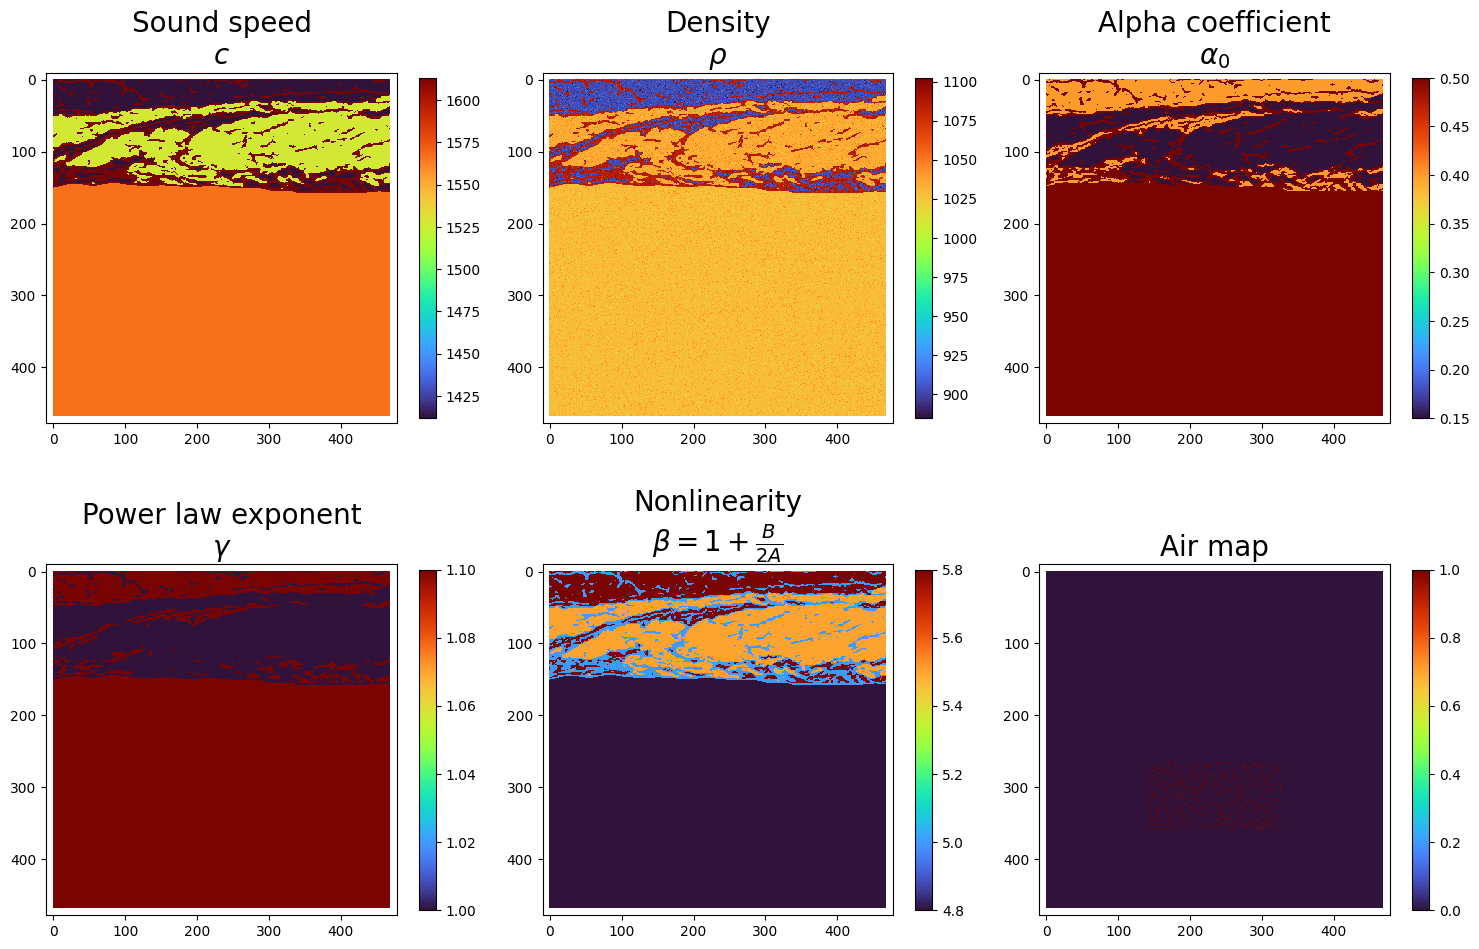

In [9]:
medium.plot(
    show=True,
    export_path=work_dir / "medium.png",
    dpi=50,
)

`Medium` class summarizes the medium properties and provides a visualization method to plot the sound speed, density, attenuation coefficient, and nonlinearity parameter distributions.

We can print the summary of the medium properties using the `print_info` method similar to the `Grid` class.


In [10]:
medium.print_info()

Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.00e-02 m, 6.00e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 7.79e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (468, 468)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4675
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1412.00, max=1613.00
  Density: min=884.50, max=1102.49
  Alpha coeff: min=0.15, max=0.50
  Alpha power: min=1.00, max=1.10
  Beta: min=4.80, max=5.80
  Number of air coords: 1880
  Attenuation builder: lookup



### Step 2.3: Define the transducer


In [11]:
element_layer_px = 3
transducer_geometry = fullwave.TransducerGeometry(
    grid,
    number_elements=128,
    # -
    element_width_m=0.146484375e-3,
    # -
    element_spacing_m=0.146484375e-3,
    # -
    element_layer_px=element_layer_px,
    # -
    # [axial, lateral]
    position_m=(
        0,
        (60 - 37.4) / 2 * 1e-3,
    ),
    # -
    radius=float("inf"),
)
transducer = fullwave.Transducer(
    transducer_geometry=transducer_geometry,
    grid=grid,
)
p_max = 1e5

angle = 0
# length = 1000000
length = int(grid.nx * (9 / 10))
target_location_px = np.array(
    [
        length * np.cos(np.deg2rad(angle)),
        length * np.sin(np.deg2rad(angle)) + grid.ny // 2,
    ],
    dtype=int,
)

active_source_elements = np.zeros(transducer_geometry.number_elements, dtype=bool)
active_sensor_elements = np.zeros(transducer_geometry.number_elements, dtype=bool)
active_source_elements[:] = True
# active_source_elements[32:96] = True
active_sensor_elements[:] = True

input_signal = np.zeros((transducer.n_sources, grid.nt))
dict_source_index_to_location = transducer.dict_source_index_to_location
element_id_to_element_center = transducer.element_id_to_element_center

delay_list = []
for i_source_index in range(len(input_signal)):
    source_location = dict_source_index_to_location[i_source_index + 1]
    element_id = transducer.transducer_geometry.indexed_element_mask_input[*source_location]
    source_location = element_id_to_element_center[element_id]

    delay_sec = np.sqrt(np.sum((target_location_px - source_location) ** 2)) * grid.dx / c0
    delay_list.append(delay_sec)
delay_list = np.array(delay_list)
delay_list = delay_list.max() - delay_list
delay_list = delay_list - delay_list.min()

for i_source_index in range(len(input_signal)):
    delay_sec = delay_list[i_source_index]
    source_location = dict_source_index_to_location[i_source_index + 1]

    n_y = input_signal.shape[0] // element_layer_px
    i_layer = i_source_index // n_y
    element_id = transducer.transducer_geometry.indexed_element_mask_input[*source_location]
    if not active_source_elements[element_id - 1]:
        p0_vec = np.zeros(grid.nt)
    else:
        p0_vec = fullwave.utils.pulse.gaussian_modulated_sinusoidal_signal(
            nt=grid.nt,
            f0=f0,
            duration=duration,
            ncycles=2,
            drop_off=2,
            p0=p_max,
            i_layer=i_layer,
            dt_for_layer_delay=grid.dt,
            cfl_for_layer_delay=grid.cfl,
            delay_sec=delay_sec,
        )
    input_signal[i_source_index, :] = p0_vec.copy()

transducer.set_signal(input_signal)

In [12]:
# make a sensor for whole domain to make an animation
sensor_mask = np.zeros((grid.nx, grid.ny), dtype=bool)
sensor_mask[:, :] = True
sensor = fullwave.Sensor(mask=sensor_mask, sampling_modulus_time=2)
sensor.plot(export_path=work_dir / "sensor_whole.svg")

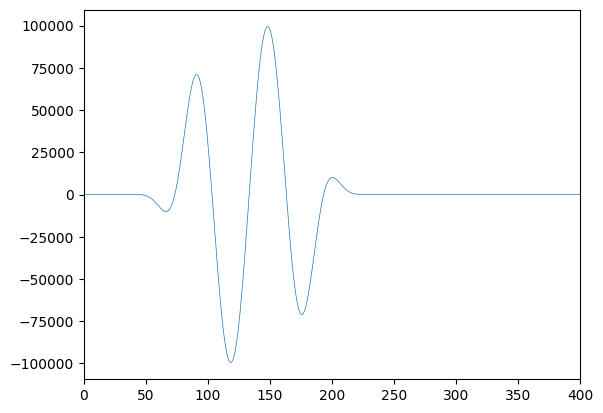

In [13]:
plot_utils.plot_1d_array(
    p0_vec,
    show=True,
    xlim=(0, 400),
    export_path=work_dir / "source_signal.png",
    dpi=30,
)

We can also visualise the source signal matrix using the plot_array function from the plot_utils module.


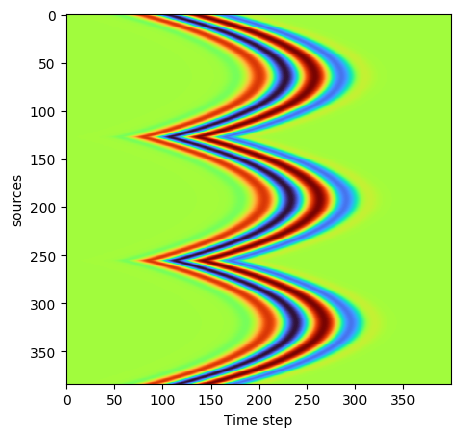

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
plot_utils.plot_array(
    input_signal[:, :400],
    show=True,
    export_path=work_dir / "source_signal_matrix.png",
    xlabel="Time step",
    ylabel="sources",
    dpi=30,
)

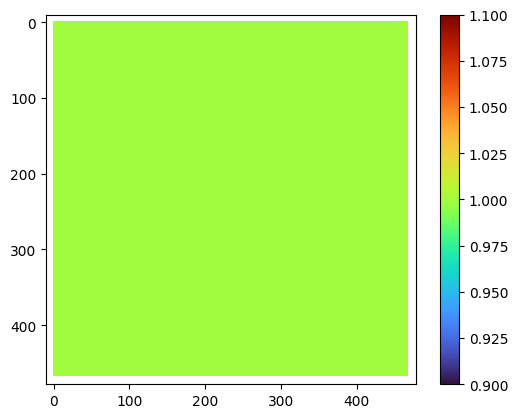

In [15]:
sensor.plot(
    show=True,
    export_path=work_dir / "sensor.png",
    dpi=30,
)

## Step 3. Simulation setup

The simulation configuration is done!
Next, we pass the configured parameters to the Fullwave solver.


### Step 3.1: Initialize the Fullwave solver object with the defined parameters. (`fullwave.Solver`)

The `Solver` class takes the working directory (`work_dir`), computational grid (`grid`), acoustic medium (`medium`), acoustic source (`source`), and sensor (`sensor`) as inputs to create a solver object that can be used to run the wave propagation simulation.

We can specify additional parameters such as `run_on_memory`
`run_on_memory` set to `True` can speed up the simulation significantly, but it requires more RAM. If you have sufficient memory, you can set it to `True` for faster execution. This is especially useful for large-scale simulations where disk I/O can become a bottleneck.
However, The simulation output will be writtein in memory and will not be saved to disk when `run_on_memory` is set to `True`. Make sure to consider this when choosing the setting based on your system's capabilities and simulation requirements.


In [16]:
fw_solver = fullwave.Solver(
    work_dir=work_dir,
    grid=grid,
    medium=medium,
    transducer=transducer,
    sensor=sensor,
    run_on_memory=False,
)

sensor and transducer are defined at the same time. It uses sensor instead of transducer.sensor.


We can print the summary of the solver properties using the `print_info` method similar to the `Grid` class.


In [17]:
fw_solver.print_info()


Solver(
  work_dir=outputs/linear_transducer

  medium=Medium: 
  Grid: Grid Information:
  Domain size (axial, lateral) (grid.domain_size): (6.00e-02 m, 6.00e-02 m)
  Center frequency: (grid.f0) 1.0 MHz
  Duration: (grid.duration) 7.79e-05 s
  Speed of sound (grid.c0): 1540 m/s
  Points per wavelength (PPW) (grid.ppw): 12
  Courant-Friedrichs-Lewy (CFL) number (grid.cfl): 0.2
  Wavelength (grid.wavelength): 1.54e+00 m
  Grid spacing (grid.dx, grid.dy): (1.28e-01 m, 1.28e-01 m)
  Number of grid points (grid.nx, grid.ny): (468, 468)
  Time step (grid.dt): 1.67e-08 sec
  Number of time steps (grid.nt): 4675
  is 3D simulation (grid.is_3d): False

  Sound speed: min=1412.00, max=1613.00
  Density: min=884.50, max=1102.49
  Alpha coeff: min=0.15, max=0.50
  Alpha power: min=1.00, max=1.10
  Beta: min=4.80, max=5.80
  Number of air coords: 1880
  Attenuation builder: lookup

  source=Source: 
  Number of sources: 384
  Grid shape: (468, 468)
  Is 3D: False
  p0 shape: (384, 4675)

  sensor

### Step 3.2: Execute the simulation.


Now, all of the configurations are set up, and we can run the simulation using the `run` method of the `Solver` class.
The `run` method executes the wave propagation simulation based on the defined grid, medium, source, and sensor configurations.
It performs the necessary computations to simulate the wave propagation and records the wavefield data at the specified sensor locations.


In [18]:
sensor_output = fw_solver.run()

## Step 4. Post-process

The simulation is complete!
Next, we will load and visualize the recorded wavefield data.


### Step 4.1 reshape the recorded wavefield data.

`sensor_output` contains the recorded wavefield data at the sensor locations after the simulation is complete.
But the data is in 1D array format, so we need to reshape it back to the original 2D grid format for further analysis and visualization.

We can use `signal_process.reshape_whole_sensor_to_nt_nx_ny` function from the `fullwave.utils.signal_process` module to reshape the recorded wavefield data.


In [19]:
propagation_map = signal_process.reshape_whole_sensor_to_nt_nx_ny(
    sensor_output,
    grid,
)

### Step 4.2. visualize the results.

We can visualize the wave propagation using the `plot_utils.plot_array` function from the `fullwave.utils.plot_utils` module.


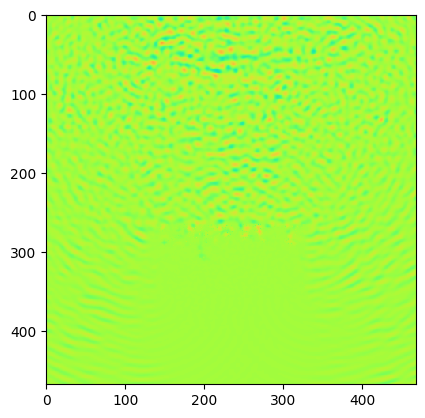

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [20]:
p_max_plot = np.abs(propagation_map).max().item() / 2
time_step = propagation_map.shape[0] // 10 * 7
plot_utils.plot_array(
    propagation_map[time_step, :, :],
    aspect=propagation_map.shape[2] / propagation_map.shape[1],
    export_path=work_dir / "wave_propagation_snapshot_1.png",
    vmax=p_max_plot,
    vmin=-p_max_plot,
    show=True,
    dpi=80,
)

We can visualize the wave propagation animation using the `plot_utils.plot_wave_propagation_with_map` function from the `fullwave.utils.plot_utils` module as well.


In [21]:
plot_utils.plot_wave_propagation_with_map(
    propagation_map=propagation_map,
    c_map=medium.sound_speed,
    rho_map=medium.density,
    export_name=work_dir / "wave_propagation_animation.gif",
    vmax=p_max_plot,
    vmin=-p_max_plot,
    figsize=(3.5, 4),
    xlabel="Lateral position (mm)",
    ylabel="Axial position (mm)",
    extent=[
        -domain_size[1] / 2 * 1e3,
        domain_size[1] / 2 * 1e3,
        domain_size[0] * 1e3,
        0,
    ],
    dpi=100,
)

plotting animation: 100%|██████████| 51/51 [00:00<00:00, 1220.55it/s]


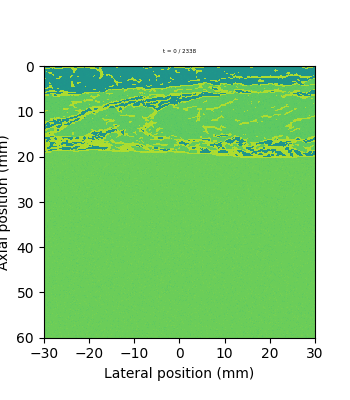

In [22]:
# show work_dir / "wave_propagation_animation.gif"
from IPython.display import Image

Image(filename=work_dir / "wave_propagation_animation.gif")

We can also visualize the recorded signals at specific sensor locations such as the transducer surface.


In [23]:
surface_signals = propagation_map[:, transducer_geometry.element_layer_px]  # [nt, n_elements]

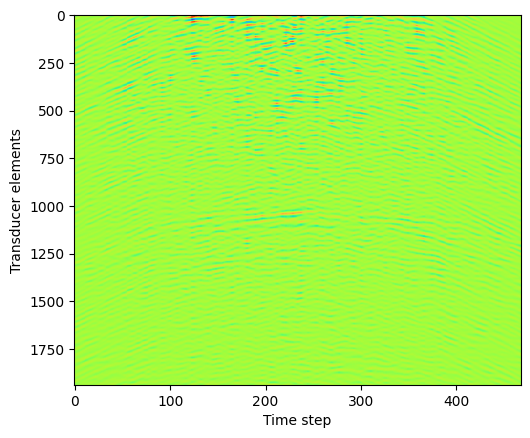

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [24]:
plot_utils.plot_array(
    surface_signals[400:],
    xlabel="Time step",
    ylabel="Transducer elements",
    export_path=work_dir / "surface_signals.png",
    dpi=30,
    show=True,
    vmax=p_max_plot,
    vmin=-p_max_plot,
    aspect=0.2,
)